# Denoising dirty documents
The dataset can be found on this [Kaggle site](https://www.kaggle.com/competitions/denoising-dirty-documents/data).

#1. Setup Kaggle API
## 1.1 Install Kaggle dependency

In [1]:
!pip install -q kaggle

#1.2 Upload Kaggle json file

In [2]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"hahalim","key":"ce68a07f66f1bdfcaa4088307943d0e2"}'}

##1.3 Make a hidden directory at root and copy the Kaggle file onto the path

In [3]:
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle

##1.4 Change the permission status of the Kaggle file

In [4]:
!chmod 600 ~/.kaggle/kaggle.json

##1.5 Test if Kaggle API is working or not

In [5]:
!kaggle datasets list

ref                                                             title                                               size  lastUpdated          downloadCount  voteCount  usabilityRating  
--------------------------------------------------------------  -------------------------------------------------  -----  -------------------  -------------  ---------  ---------------  
myrios/cost-of-living-index-by-country-by-number-2024           Cost of Living Index by Country                      3KB  2024-07-19 06:25:42           3931         57  1.0              
muhammadroshaanriaz/cancer-dataset-risk-of-developing-or-dying  Cancer Dataset (Risk of Developing or Dying)        867B  2024-07-26 20:30:18           1095         21  1.0              
muhammadehsan000/2024-electric-car-data-washington-state        Electric Vehicle Data (1997 - 2024)                  6MB  2024-08-04 10:33:24           1373         36  1.0              
muhammadehsan000/olympic-historical-dataset-1896-2020           O

##1.6 Download the zip file

In [6]:
!kaggle competitions download -c denoising-dirty-documents

 92% 33.0M/35.7M [00:01<00:00, 33.3MB/s]
100% 35.7M/35.7M [00:01<00:00, 30.8MB/s]


#2. Data preprocessing
##2.1 Unzip the dataset

In [7]:
!unzip -q denoising-dirty-documents.zip

##2.2 Make a new directory and store the dataset into the newly created directory

In [8]:
import os
import zipfile
train_dir = "doc_dataset"
os.makedirs(train_dir, exist_ok=True)

with zipfile.ZipFile("train.zip") as f:
    f.extractall(train_dir)

with zipfile.ZipFile("train_cleaned.zip") as f:
    f.extractall(train_dir)

##2.3 Store the images in `train` and `train_cleaned` directories as NumPy arrays

In [9]:
train_img_filename = sorted(os.listdir(os.path.join(train_dir, "train")))
train_cleaned_img_filename = sorted(os.listdir(os.path.join(train_dir, "train_cleaned")))

In [10]:
print("Number of training image:", len(train_img_filename))
print("Number of clean image:", len(train_cleaned_img_filename))

Number of training image: 144
Number of clean image: 144


In [11]:
print(train_img_filename[:5])
print(train_cleaned_img_filename[:5])

['101.png', '102.png', '104.png', '105.png', '107.png']
['101.png', '102.png', '104.png', '105.png', '107.png']


In [12]:
import cv2 as cv
import numpy as np

# new image size
SIZE = 480
def preprocess_img(img_filename):
    img = cv.imread(img_filename, cv.IMREAD_GRAYSCALE)
    img = cv.resize(img, (SIZE, SIZE), interpolation=cv.INTER_CUBIC)
    img = img.astype("float32") / 255.0
    img = np.expand_dims(img, -1)
    return img

In [13]:
x_train = []
y_train = []

for file_name in train_img_filename:
    x_train.append(preprocess_img(os.path.join(train_dir, "train", file_name)))

for file_name in train_cleaned_img_filename:
    y_train.append(preprocess_img(os.path.join(train_dir, "train_cleaned", file_name)))

In [14]:
# sanity checking
x_train = np.array(x_train, dtype=np.float32)
y_train = np.array(y_train, dtype=np.float32)
print("The size of x_train:", x_train.shape)
print("The size of y_train:", y_train.shape)

The size of x_train: (144, 480, 480, 1)
The size of y_train: (144, 480, 480, 1)


#3. Data visualization

In [15]:
import matplotlib.pyplot as plt

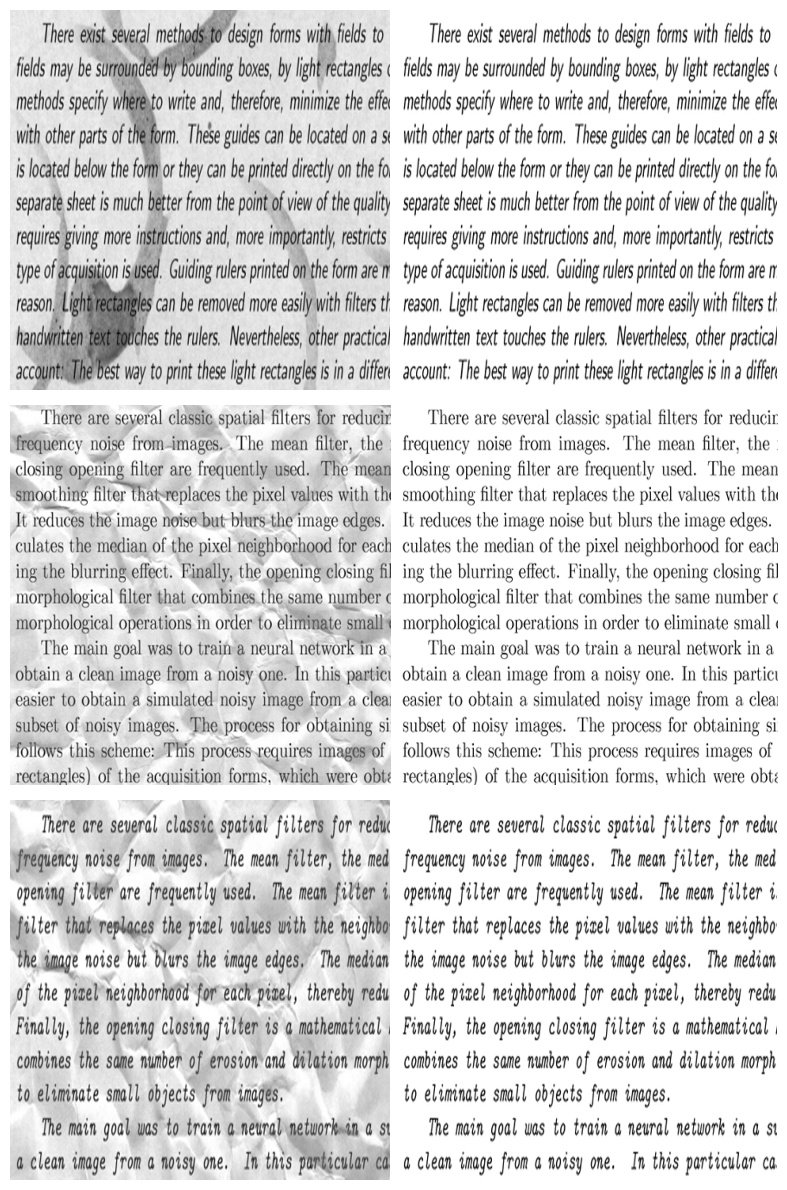

In [16]:
# Display random 3 image pairs
rng = np.random.default_rng()
indices = rng.choice(x_train.shape[0], 3)

fig, ax = plt.subplots(3, 2, figsize=(8, 12))
x_train_plot = x_train[indices]
y_train_plot = y_train[indices]

for i, (noise, clean) in enumerate(zip(x_train_plot, y_train_plot)):
    ax[i][0].imshow(np.squeeze(noise), cmap="gray")
    ax[i][0].axis("off")
    ax[i][1].imshow(np.squeeze(clean), cmap="gray")
    ax[i][1].axis("off")

plt.tight_layout()
plt.show()

#4. Model architecture
**Autoencoder**
##4.1 Define autoencoder architecture

In [17]:
from tensorflow import keras
import tensorflow as tf
from tensorflow.keras import layers

In [18]:
inputs = keras.Input(shape=x_train.shape[1:])
# autoencoder (encoder)
x = layers.Conv2D(32, kernel_size=(3, 3), activation="relu",
                  padding="same", kernel_initializer="he_normal")(inputs)
x = layers.MaxPooling2D(pool_size=(2, 2))(x)
x = layers.Conv2D(64, kernel_size=(3, 3), activation="relu",
                  padding="same", kernel_initializer="he_normal")(x)
x = layers.MaxPooling2D(pool_size=(2, 2))(x)
x = layers.Conv2D(128, kernel_size=(3, 3), activation="relu",
                  padding="same", kernel_initializer="he_normal")(x)
# Decoder
x = layers.UpSampling2D(size=(2, 2))(x)
x = layers.Conv2D(64, kernel_size=(3, 3), activation="relu",
                  padding="same", kernel_initializer="he_normal")(x)
x = layers.UpSampling2D(size=(2, 2))(x)
x = layers.Conv2D(32, kernel_size=(3, 3), activation="relu",
                  padding="same", kernel_initializer="he_normal")(x)

# map to outputs
output = layers.Conv2D(1, kernel_size=(3, 3), activation="sigmoid",
                       padding="same")(x)

model = keras.Model(inputs, output)
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 480, 480, 1)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 480, 480, 32)        │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 240, 240, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 240, 240, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 120, 120, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 120, 120, 128)       │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ up_sampling2d (UpSampling2D)         │ (None, 240, 240, 128)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 240, 240, 64)        │          73,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ up_sampling2d_1 (UpSampling2D)       │ (None, 480, 480, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 480, 480, 32)        │          18,464 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 480, 480, 1)         │             289 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 185,217 (723.50 KB)

 Trainable params: 185,217 (723.50 KB)

 Non-trainable params: 0 (0.00 B)

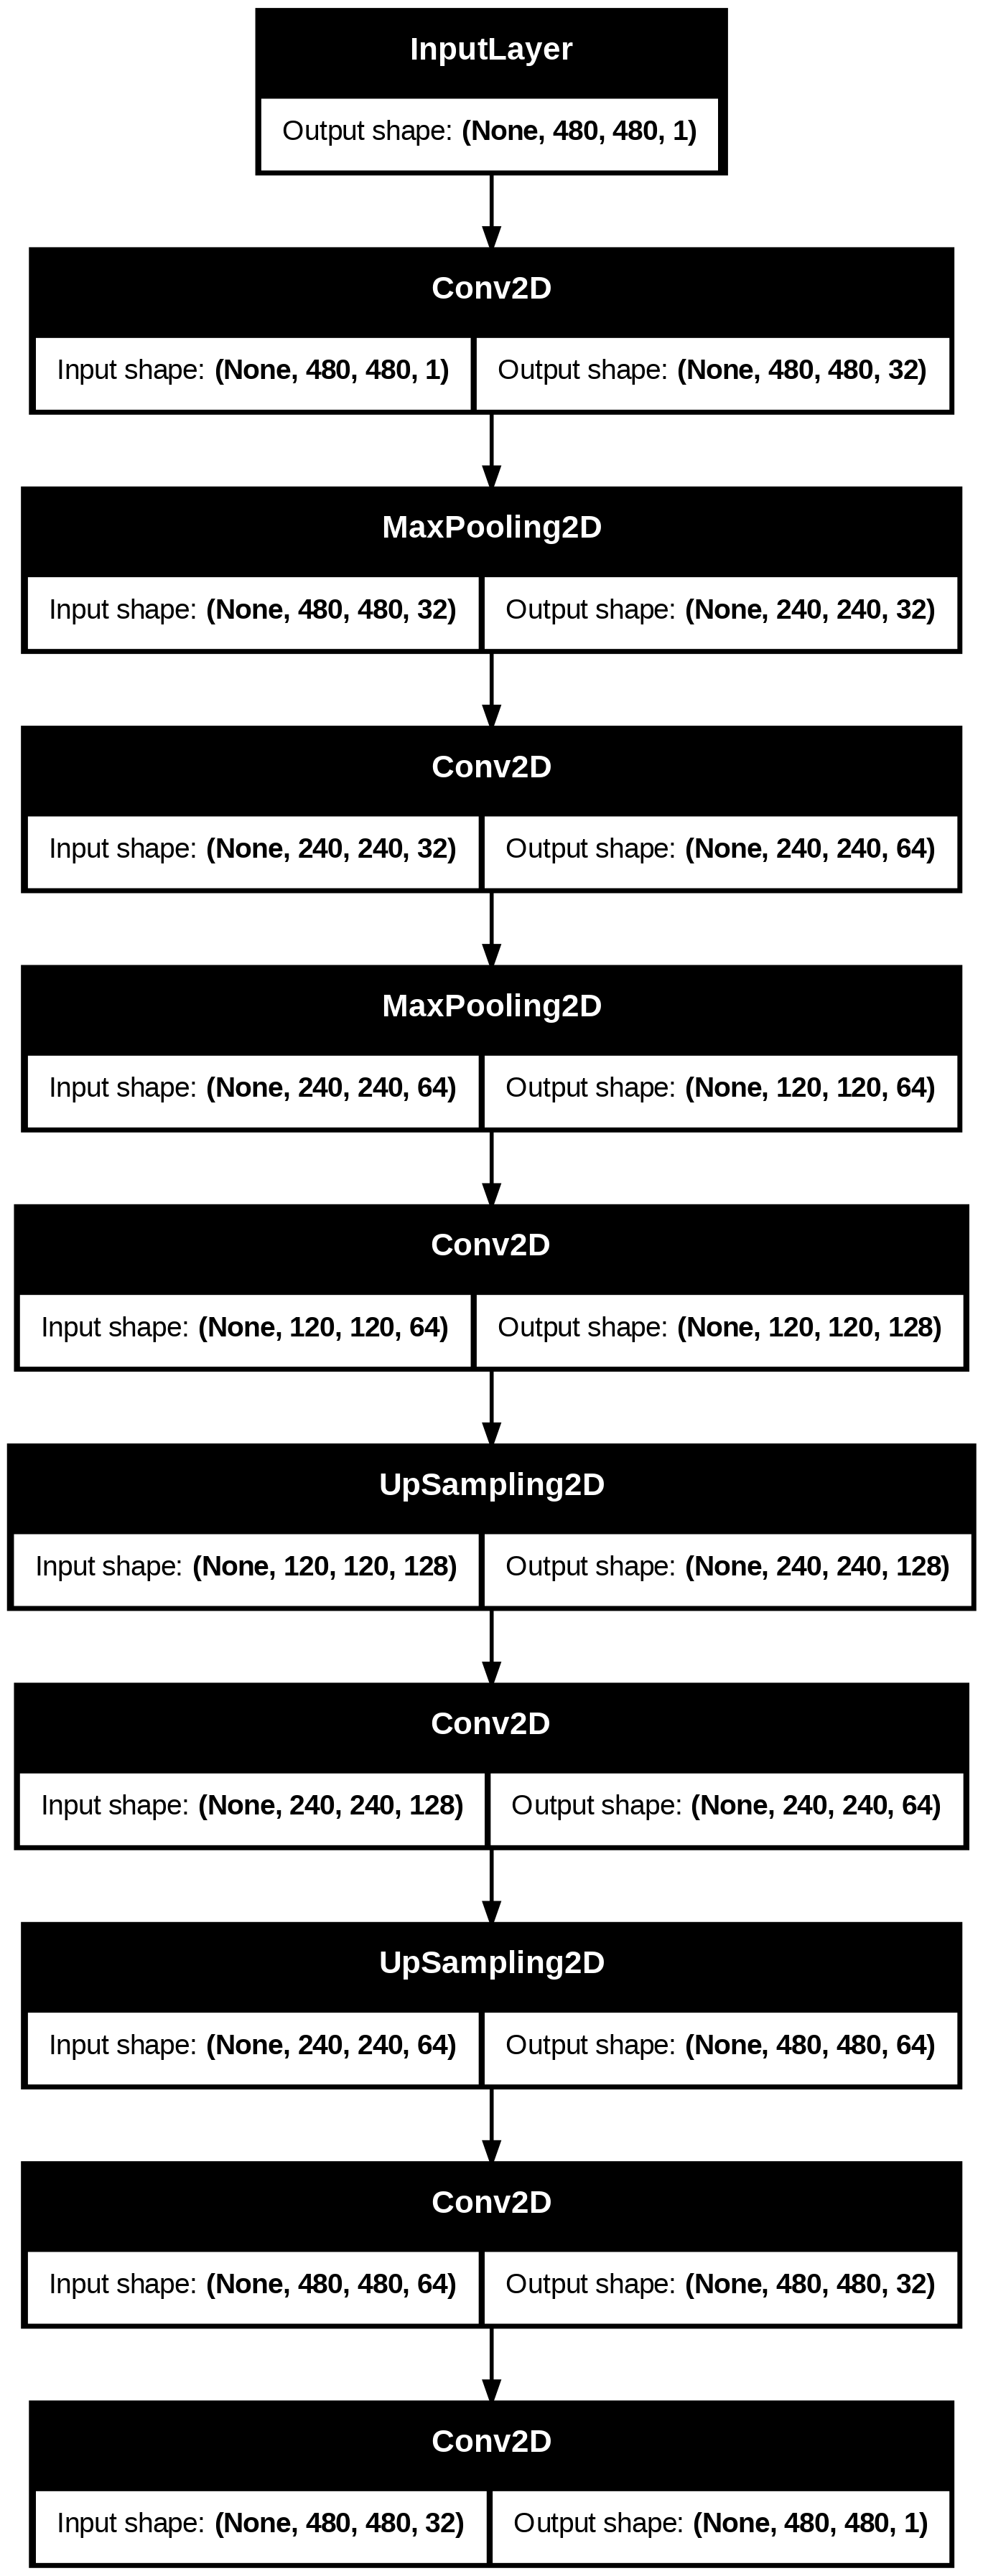

In [19]:
from tensorflow.keras.utils import plot_model

plot_model(model, to_file="autoencoder_denoise.png", show_shapes=True)

##4.2 Compile model

In [20]:
model.compile(
    optimizer=keras.optimizers.RMSprop(),
    loss=keras.losses.MeanSquaredError(),
    metrics=['mae']
)

##4.3 Train the model

In [35]:
epochs = 100
batch_size = 32
model_filepath = "autoencoder_denoise.keras"

callbacks = [
    keras.callbacks.ModelCheckpoint(model_filepath, save_best_only=True),
    keras.callbacks.EarlyStopping(monitor="loss", patience=10)
]

history = model.fit(
    x_train,
    y_train,
    epochs=epochs,
    batch_size=batch_size,
    callbacks=callbacks,
    shuffle=True,
    validation_split=0.1
)

Epoch 1/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 78s 5s/step - loss: 0.0819 - mae: 0.1153 - val_loss: 0.0703 - val_mae: 0.1011
Epoch 2/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 577ms/step - loss: 0.0807 - mae: 0.1145 - val_loss: 0.0703 - val_mae: 0.1011
Epoch 3/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 5s 558ms/step - loss: 0.0805 - mae: 0.1143 - val_loss: 0.0703 - val_mae: 0.1012
Epoch 4/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 5s 577ms/step - loss: 0.0807 - mae: 0.1147 - val_loss: 0.0703 - val_mae: 0.1012
Epoch 5/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 5s 556ms/step - loss: 0.0805 - mae: 0.1147 - val_loss: 0.0703 - val_mae: 0.1012
Epoch 6/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 5s 575ms/step - loss: 0.0803 - mae: 0.1143 - val_loss: 0.0703 - val_mae: 0.1013
Epoch 7/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 574ms/step - loss: 0.0812 - mae: 0.1153 - val_loss: 0.0703 - val_mae: 0.1014
Epoch 8/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 5s 566ms/step - loss: 0.0805 - mae: 0.1145 - val_loss: 0.0702 - val_mae: 0.1021
Epoch 9/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 5s 579ms/step - loss: 0.1550 

##4.4 Plot learning curves

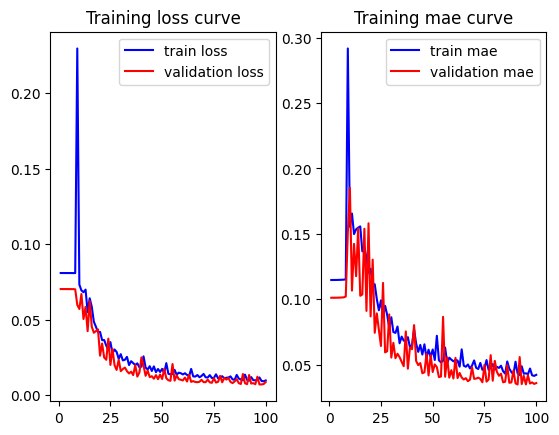

In [36]:
loss = history.history["loss"]
val_loss = history.history["val_loss"]
mae = history.history['mae']
val_mae = history.history['val_mae']
# len(loss)
plt.subplot(121)
plt.plot(range(1, len(loss)+1), loss, "b-", label="train loss")
plt.plot(range(1, len(val_loss)+1), val_loss, "r-", label="validation loss")
plt.legend()
plt.title("Training loss curve")

plt.subplot(122)
plt.plot(range(1, len(mae)+1), mae, "b-", label="train mae")
plt.plot(range(1, len(val_mae)+1), val_mae, "r-", label="validation mae")
plt.legend()
plt.title("Training mae curve")

plt.show()

#5. Model evaluation

##5.1 load model

In [26]:
load_model = keras.models.load_model(model_filepath)

##5.2 Make prediction on test image

In [24]:
test_dir = "test_data"

os.makedirs(test_dir, exist_ok=True)

with zipfile.ZipFile("test.zip") as f:
    f.extractall(test_dir)

In [25]:
test_img_filenames = os.listdir(os.path.join(test_dir, "test"))
test_img_filenames

['136.png',
 '55.png',
 '145.png',
 '202.png',
 '85.png',
 '79.png',
 '19.png',
 '103.png',
 '205.png',
 '151.png',
 '91.png',
 '40.png',
 '1.png',
 '64.png',
 '31.png',
 '148.png',
 '46.png',
 '88.png',
 '118.png',
 '127.png',
 '115.png',
 '82.png',
 '166.png',
 '94.png',
 '61.png',
 '142.png',
 '7.png',
 '211.png',
 '109.png',
 '214.png',
 '172.png',
 '181.png',
 '133.png',
 '16.png',
 '193.png',
 '28.png',
 '67.png',
 '124.png',
 '169.png',
 '70.png',
 '157.png',
 '178.png',
 '112.png',
 '22.png',
 '4.png',
 '190.png',
 '76.png',
 '13.png',
 '97.png',
 '37.png',
 '52.png',
 '43.png',
 '58.png',
 '106.png',
 '154.png',
 '130.png',
 '25.png',
 '73.png',
 '10.png',
 '34.png',
 '100.png',
 '196.png',
 '199.png',
 '187.png',
 '139.png',
 '160.png',
 '208.png',
 '121.png',
 '184.png',
 '49.png',
 '175.png',
 '163.png']

In [37]:
test_img = preprocess_img(os.path.join(test_dir, "test", test_img_filenames[1]))
test_img = np.expand_dims(test_img, 0)

# pred = load_model.predict(test_img)
pred = model.predict(test_img)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 280ms/step


In [31]:
pred.shape

(1, 480, 480, 1)

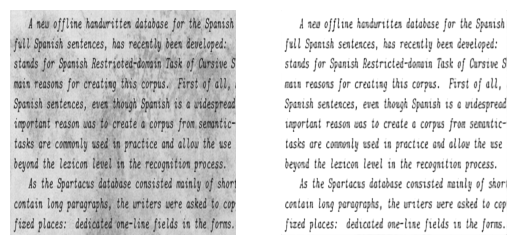

In [38]:
plt.subplot(121)
plt.imshow(np.squeeze(test_img), cmap="gray")
plt.axis("off")

plt.subplot(122)
plt.imshow(np.squeeze(pred), cmap="gray")
plt.axis("off")

plt.show()